## ML Pipeline
### Melanie Peña

In [71]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pymysql
from dotenv import load_dotenv

load_dotenv()

SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

os.makedirs("outputs", exist_ok=True)
print("Librerías cargadas correctamente")

Librerías cargadas correctamente


## 1. EObtener datos

Para obtener los datos, realizamos una conexión con los datos almacenado en la BD, en mi caso, estan almacenados en MariaDB. Se extraen los datos con una query y se almacenan 
en un pandas DataFrame

In [72]:
# estos datos vienen del archivo .env que debe configurarse para la conexión tanto de este notebook como el de generate_data
DB_CONFIG = {
    "host":     os.getenv("DB_HOST"),
    "port":     int(os.getenv("DB_PORT")),
    "user":     os.getenv("DB_USER"),
    "password": os.getenv("DB_PASSWORD"),
    "database": os.getenv("DB_NAME"),
}

# Datos relevantes para el modelo
# LEFT JOIN en médicos porque no todas las sesiones tienen registro médico
# LEFT JOIN en eva_units para traer el estado y activation_count de la unidad asignada
# JOIN con los pilotos para obtener su edad
# datos como los nombres de los pilotos no son relavantes aL ser únicos
QUERY = """
SELECT s.session_id,
       s.pilot_id,
       s.unit_id,
       s.sync_rate,
       s.session_date,
       s.duration_min,
       s.mental_contamination,
       s.status,
       m.heart_rate_avg,
       m.neural_stress,
       m.recovery_hours,
       e.activation_count,
       e.status AS unit_status,
       p.age 
FROM sync_sessions s
         LEFT JOIN pilot_medical m ON s.session_id = m.session_id
         LEFT JOIN eva_units e ON s.unit_id = e.unit_id
         JOIN pilots p ON s.pilot_id = p.pilot_id 
ORDER BY s.pilot_id, s.session_date
"""

conn = pymysql.connect(**DB_CONFIG)
df = pd.read_sql(QUERY, conn)
conn.close() #importante cerrar la sesión
df.tail()

C:\Users\Asus\AppData\Local\Temp\ipykernel_20644\1859134091.py:38: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(QUERY, conn)


,session_id,pilot_id,unit_id,sync_rate,session_date,duration_min,mental_contamination,status,heart_rate_avg,neural_stress,recovery_hours,activation_count,unit_status,age
220,221,PILOT-008,EVA-02,87.30,2026-01-11 21:55:00,62,2.09,completed,70.0,27.88,7.15,40,operational,17
221,222,PILOT-008,EVA-01,10.26,2026-02-02 11:17:00,72,61.40,aborted,102.0,52.16,11.77,8,operational,17
222,223,PILOT-008,EVA-02,83.10,2026-02-05 13:52:00,72,3.67,completed,65.0,29.60,2.50,40,operational,17
223,224,PILOT-008,EVA-00,41.49,2026-02-09 17:15:00,64,15.86,completed,86.0,24.80,7.15,19,operational,17
224,225,PILOT-008,EVA-03,22.45,2026-02-11 09:53:00,106,12.75,completed,98.0,37.17,3.38,36,maintenance,17


## 2. EDA

Se realiza un EDA rápido sobre los datos

In [73]:
print("Valores nulos:")
print(df.isnull().sum())

Valores nulos:
session_id               0
pilot_id                 0
unit_id                  0
sync_rate                0
session_date             0
duration_min             0
mental_contamination     0
status                   0
heart_rate_avg          30
neural_stress           30
recovery_hours          30
activation_count         0
unit_status              0
age                      0
dtype: int64


In [74]:
print("Tipos de datos:")
print(df.dtypes)

Tipos de datos:
session_id                       int64
pilot_id                           str
unit_id                            str
sync_rate                      float64
session_date            datetime64[us]
duration_min                     int64
mental_contamination           float64
status                             str
heart_rate_avg                 float64
neural_stress                  float64
recovery_hours                 float64
activation_count                 int64
unit_status                        str
age                              int64
dtype: object


In [75]:
print("Stats generales:")
df.describe()

Stats generales:


,session_id,sync_rate,session_date,duration_min,mental_contamination,heart_rate_avg,neural_stress,recovery_hours,activation_count,age
count,225.000000,225.000000,225,225.000000,225.000000,195.000000,195.000000,195.000000,225.000000,225.000000
mean,113.000000,46.972356,2025-08-17 05:09:22.133333,66.791111,28.215511,91.010256,28.311333,7.729641,22.253333,18.244444
min,1.000000,1.270000,2025-03-04 17:36:00,15.000000,0.140000,65.000000,5.320000,2.010000,8.000000,16.000000
25%,57.000000,23.400000,2025-05-13 19:03:00,42.000000,14.760000,76.000000,14.700000,3.945000,8.000000,17.000000
50%,113.000000,44.220000,2025-08-10 17:43:00,66.000000,23.580000,88.000000,23.390000,5.760000,22.000000,17.000000
75%,169.000000,69.060000,2025-11-25 11:53:00,96.000000,34.560000,97.000000,35.225000,7.170000,36.000000,18.000000
max,225.000000,99.860000,2026-02-24 19:46:00,120.000000,88.760000,170.000000,98.500000,43.190000,40.000000,32.000000
std,65.096083,28.214342,NaN,30.198095,20.468994,21.843395,19.820574,7.910476,12.082410,3.246946


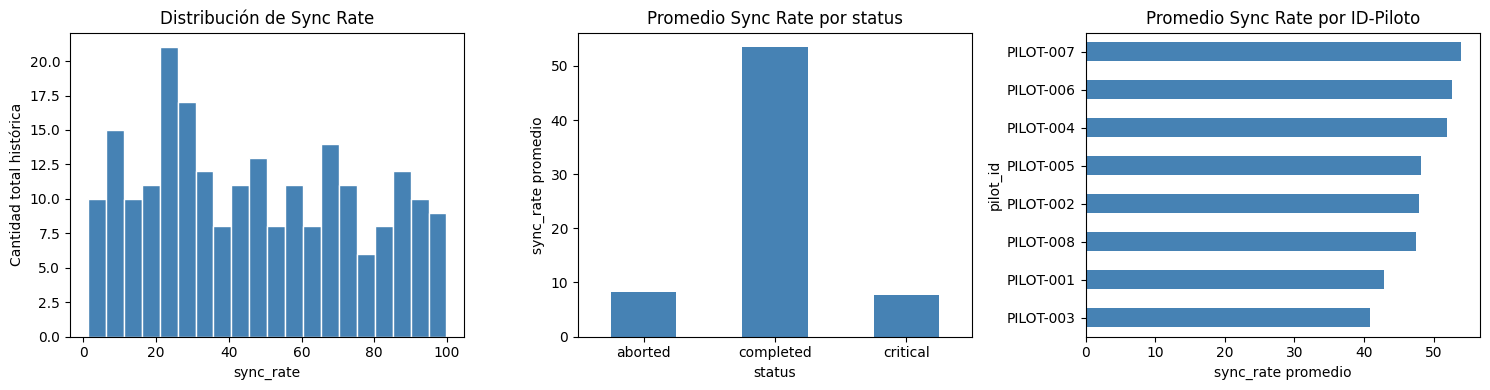

In [76]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Distribución de sync_rate
axes[0].hist(df['sync_rate'], bins=20, color='steelblue', edgecolor='white')
axes[0].set_title('Distribución de Sync Rate')
axes[0].set_xlabel('sync_rate')
axes[0].set_ylabel('Cantidad total histórica')

# Sync rate promedio por estado de sesión
df.groupby('status')['sync_rate'].mean().plot(kind='bar', ax=axes[1], color='steelblue')
axes[1].set_title('Promedio Sync Rate por status')
axes[1].set_ylabel('sync_rate promedio')
axes[1].tick_params(axis='x', rotation=0)

# Sync rate promedio por piloto
df.groupby('pilot_id')['sync_rate'].mean().sort_values().plot(kind='barh', ax=axes[2], color='steelblue')
axes[2].set_title('Promedio Sync Rate por ID-Piloto')
axes[2].set_xlabel('sync_rate promedio')

plt.tight_layout()
plt.savefig('outputs/eda.png', dpi=150, bbox_inches='tight')
plt.show()

## 3. Feature Engineering

Se comienza la sección feature engineering teniendo en cuenta que la variable objetivo corresponde a el sync_rate de la sesión actual.


In [77]:
# Ordenamos por orden cronogioco
df = df.sort_values(['pilot_id', 'session_date']).reset_index(drop=True)
df

,session_id,pilot_id,unit_id,sync_rate,session_date,duration_min,mental_contamination,status,heart_rate_avg,neural_stress,recovery_hours,activation_count,unit_status,age
0,1,PILOT-001,EVA-04,7.88,2025-03-04 17:36:00,39,83.18,critical,170.0,70.11,19.15,33,destroyed,17
1,2,PILOT-001,EVA-01,4.58,2025-03-14 08:54:00,44,80.92,aborted,NaN,NaN,NaN,8,operational,17
2,3,PILOT-001,EVA-04,27.80,2025-03-16 17:10:00,62,25.43,completed,73.0,31.56,4.81,33,destroyed,17
3,4,PILOT-001,EVA-01,67.02,2025-03-17 08:38:00,96,28.07,completed,70.0,5.67,3.29,8,operational,17
4,5,PILOT-001,EVA-01,72.91,2025-03-23 18:17:00,96,6.54,completed,98.0,19.81,6.66,8,operational,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220,221,PILOT-008,EVA-02,87.30,2026-01-11 21:55:00,62,2.09,completed,70.0,27.88,7.15,40,operational,17
221,222,PILOT-008,EVA-01,10.26,2026-02-02 11:17:00,72,61.40,aborted,102.0,52.16,11.77,8,operational,17
222,223,PILOT-008,EVA-02,83.10,2026-02-05 13:52:00,72,3.67,completed,65.0,29.60,2.50,40,operational,17
223,224,PILOT-008,EVA-00,41.49,2026-02-09 17:15:00,64,15.86,completed,86.0,24.80,7.15,19,operational,17


In [78]:
# Del EDA anterior notamos que hay valores nulos en loa features medicos. Se rellenan los nulos con la mediana del piloto
# Si un piloto no tiene ningún registro médico, se usa la mediana global. Como mejora futura, se pueden
# usar técnicnas como imputacion KNN o MICE
columnas_medicas = ['heart_rate_avg', 'neural_stress', 'recovery_hours']

for col in columnas_medicas:
    mediana_por_piloto = df.groupby('pilot_id')[col].transform('median')
    df[col] = df[col].fillna(mediana_por_piloto)
    df[col] = df[col].fillna(df[col].median())


In [79]:
print(df.isnull().sum())

session_id              0
pilot_id                0
unit_id                 0
sync_rate               0
session_date            0
duration_min            0
mental_contamination    0
status                  0
heart_rate_avg          0
neural_stress           0
recovery_hours          0
activation_count        0
unit_status             0
age                     0
dtype: int64


In [80]:
# El status de la unidad es una variable categórica (texto), por lo que nes necesario
# convertirla a formato numérico para que el modelo pueda procesarla.
unit_status_map   = {'operational': 2, 'maintenance': 1, 'destroyed': 0}
df['unit_status_encoded'] = df['unit_status'].map(unit_status_map).fillna(1)
# rellenar con 0 por seguridad
df['activation_count'] = df['activation_count'].fillna(0)

In [81]:
df['unit_status_encoded']

0      0
1      2
2      0
3      2
4      2
      ..
220    2
221    2
222    2
223    2
224    1
Name: unit_status_encoded, Length: 225, dtype: int64

In [82]:
# Se calcula cuántos días pasaron entre la sesión actual y la sesión anterior del mismo piloto.
# diff() calcula la diferencia entre fechas consecutivas dentro de cada grupo de piloto
df['dias_desde_sesion_anterior'] = df.groupby('pilot_id')['session_date'].diff().dt.days
# se rellena con 0 por seguridad
df['dias_desde_sesion_anterior'] = df['dias_desde_sesion_anterior'].fillna(0)

In [83]:
df['dias_desde_sesion_anterior'] 

0       0.0
1       9.0
2       2.0
3       0.0
4       6.0
       ... 
220     6.0
221    21.0
222     3.0
223     4.0
224     1.0
Name: dias_desde_sesion_anterior, Length: 225, dtype: float64

In [84]:
# Para construir los features de historial, agrupamos las sesiones por piloto
# y usamos shift(1) para mirar siempre hacia atrás, nunca hacia la sesión actual.
# Esto es importante para evitar que el modelo conozca usando datos del futuro y se cree un data leakage
sesiones_por_piloto = df.groupby('pilot_id')['sync_rate']

# sync_last y sync_last2 son simplemente el sync_rate de la sesión anterior
# y de hace 2 sesiones respectivamente
# shift : f(x) - f(x-1) y así
df['sync_last']  = sesiones_por_piloto.shift(1)
df['sync_last2'] = sesiones_por_piloto.shift(2)

# El promedio y desviación histórica se calculan de forma acumulada,
# es decir, cada fila considera todas las sesiones anteriores del piloto hasta ese punto
df['sync_mean_historico'] = sesiones_por_piloto.shift(1).expanding().mean()
df['sync_std_historico']  = sesiones_por_piloto.shift(1).expanding().std()

# La tendencia captura si el piloto está por encima o por debajo de su promedio histórico.
# Un valor positivo indica mejora, uno negativo indica posible declive en 
df['tendencia_sync'] = df['sync_last'] - df['sync_mean_historico']

df['duracion_promedio_historica'] = df.groupby('pilot_id')['duration_min'].shift(1).expanding().mean()

# Las primeras sesiones de cada piloto quedan con nulos porque no tienen historial previo.
# Se rellenan con el promedio o desviación global según corresponda.
df['sync_last']                   = df['sync_last'].fillna(df['sync_rate'].mean())
df['sync_last2']                  = df['sync_last2'].fillna(df['sync_rate'].mean())
df['sync_mean_historico']         = df['sync_mean_historico'].fillna(df['sync_rate'].mean())
df['sync_std_historico']          = df['sync_std_historico'].fillna(0)
df['tendencia_sync']              = df['tendencia_sync'].fillna(0)
df['duracion_promedio_historica'] = df['duracion_promedio_historica'].fillna(df['duration_min'].mean())

In [85]:
# Queremos saber si la sesión anterior del piloto fue problemática, ya que una sesión crítica o abortada puede afectar el rendimiento siguiente.
# Se usa shift(1) para mirar el estado de la sesión anterior, no la actual.
status_anterior = df.groupby('pilot_id')['status'].shift(1)

# Si el status anterior fue 'aborted' o 'critical' se asigna el vlaor de 1, 0 en caso contrario.
# La primera sesión de cada piloto queda en 0 porque no tiene sesión previa.
df['sesion_anterior_problematica'] = status_anterior.isin(['aborted', 'critical']).astype(int)
df['sesion_anterior_problematica'] = df['sesion_anterior_problematica'].fillna(0)

In [86]:
features = [
    'sync_last', 'sync_last2', 'sync_mean_historico', 'sync_std_historico', 'tendencia_sync',
    'mental_contamination',
    'heart_rate_avg', 'neural_stress', 'recovery_hours',
    'dias_desde_sesion_anterior', 'sesion_anterior_problematica', 'duracion_promedio_historica',
    'activation_count', 'unit_status_encoded',
    'age'
]
print(f"\nShape del dataset final: {df.shape}")


Shape del dataset final: (225, 23)


In [87]:
df.head()

,session_id,pilot_id,unit_id,sync_rate,session_date,duration_min,mental_contamination,status,heart_rate_avg,neural_stress,...,age,unit_status_encoded,dias_desde_sesion_anterior,sync_last,sync_last2,sync_mean_historico,sync_std_historico,tendencia_sync,duracion_promedio_historica,sesion_anterior_problematica
0,1,PILOT-001,EVA-04,7.88,2025-03-04 17:36:00,39,83.18,critical,170.0,70.11,...,17,0,0.0,46.972356,46.972356,46.972356,0.000000,0.00,66.791111,0
1,2,PILOT-001,EVA-01,4.58,2025-03-14 08:54:00,44,80.92,aborted,88.5,18.06,...,17,2,9.0,7.880000,46.972356,7.880000,0.000000,0.00,39.000000,1
2,3,PILOT-001,EVA-04,27.80,2025-03-16 17:10:00,62,25.43,completed,73.0,31.56,...,17,0,2.0,4.580000,7.880000,6.230000,2.333452,-1.65,41.500000,1
3,4,PILOT-001,EVA-01,67.02,2025-03-17 08:38:00,96,28.07,completed,70.0,5.67,...,17,2,0.0,27.800000,4.580000,13.420000,12.562277,14.38,48.333333,0
4,5,PILOT-001,EVA-01,72.91,2025-03-23 18:17:00,96,6.54,completed,98.0,19.81,...,17,2,6.0,67.020000,27.800000,26.820000,28.695770,40.20,60.250000,0


## 4. Dividir datos


Se dividen los datos segun lo pedido por enunciado teniendo en cuenta que se debe respetar el orden temporal para evitar el data leakage posible al mirar datos del futuro

In [88]:
X = df[features].values
y = df['sync_rate'].values

In [89]:
# Split 70% train / 15% validación / 15% test
# shuffle=False para respetar el orden temporal y que no se miren datos del futuro
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=SEED, shuffle=False)
X_val,   X_test, y_val,   y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=SEED, shuffle=False)

print(f"Train:      {X_train.shape[0]} muestras")
print(f"Validación: {X_val.shape[0]} muestras")
print(f"Test:       {X_test.shape[0]} muestras")

# StandardScaler: fit SOLO en train para no filtrar información del futuro
scaler  = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val   = scaler.transform(X_val)
X_test  = scaler.transform(X_test)

Train:      157 muestras
Validación: 34 muestras
Test:       34 muestras


## 5. MODELO

In [90]:
class SyncDataset(Dataset):
    """Dataset personalizado para cargar los datos al modelo de pytorch. Se conviertn los arrays de numpy a tensores float32

    Args:
        X (np.ndarray): matriz de los features
        Y (np.ndarray): vector de la variable objetivo
    """
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_loader = DataLoader(SyncDataset(X_train, y_train), batch_size=32, shuffle=True)
val_loader   = DataLoader(SyncDataset(X_val,   y_val),   batch_size=32)
test_loader  = DataLoader(SyncDataset(X_test,  y_test),  batch_size=32)

class MAGIPredictiveCore(nn.Module):
    """Red neuronal de predicción de sync_rate de los pilotos en su próxima sesión.
        Consta de 3 capas ocultas con BatchNorm y Dropout como técnicas
    de regularización para evitar overfitting. La salida es un único valor
    continuo correspondiente al sync_rate predicho.

    Args:
        input_dim (int): Cantidad de features de entrada.
    """
    def __init__(self, input_dim):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 64), 
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(64, 32), #capa 2
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(32, 16), 
            nn.ReLU(),

            nn.Linear(16, 1)
        )

    def forward(self, x):
        """paso forward de la red

        Args:
            x (torch.Tensor): tensor de entrada

        Returns:
            torch.Tensor: predicciones de sync_rate
        """
        return self.network(x).squeeze(-1)

### Se necesita la forma de los datos de entrenamiento para que se introduzcan al modelo
INPUT_DIM = X_train.shape[1]
model     = MAGIPredictiveCore(input_dim=INPUT_DIM)
print(model)
print(f"\nParámetros entrenables: {sum(p.numel() for p in model.parameters()):,}")


MAGIPredictiveCore(
  (network): Sequential(
    (0): Linear(in_features=15, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=64, out_features=32, bias=True)
    (5): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.2, inplace=False)
    (8): Linear(in_features=32, out_features=16, bias=True)
    (9): ReLU()
    (10): Linear(in_features=16, out_features=1, bias=True)
  )
)

Parámetros entrenables: 3,841


Se eligio en este tipo de modelo neuronal dado lo sgte: 
- BatchNorm estabiliza el entrenamiento normalizando las activaciones de cada capa.
- Dropout desactiva neuronas aleatoriamente durante el entrenamiento para evitar que el modelo memorice los datos en vez de aprender patrones generales
Estos dos tipos de regularizaciones son las más comunes dentro de los modelos neuronales, los valores se ajustan a los valores tipicos usados en redes
512 - 256 -128- 56 -  32 -16. Estos valores se pueden optimizar en un paso futuro
-  La capa final tiene 1 sola neurona de salida porque es un problema de regresión y se requiere predecir un único valor: el sync_rate.


## 6. Fase de entrenamiento

Se elige el optimizador ADAM dado que es el mas usado en deep learning porque converge más rápido que SGD clásico y requiere menos ajuste manual del learning rate. Dado que el problema no corresponde a una clasificacion, perdidas como BCELoss o CrossEntropyLoss no se consideran al MSELoss, ser la funcion adecuada para este tipo de problemas de regresión.

In [91]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

EPOCHS   = 200
PATIENCE = 10

best_val_loss     = float('inf')
epochs_sin_mejora = 0
best_model_state  = None
train_losses      = []
val_losses        = []

for epoch in range(EPOCHS):

    # Fase de entrenamiento
    model.train()
    train_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        pred = model(X_batch)
        loss = criterion(pred, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)

    # Fase de validación
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            pred = model(X_batch)
            val_loss += criterion(pred, y_batch).item()
    val_loss /= len(val_loader)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    # Early stopping: guardamos el mejor modelo y esperamos PATIENCE epochs
    # en caso de que el modelo no presente mejora en estas epocas, el proceso se para 
    if val_loss < best_val_loss:
        best_val_loss     = val_loss
        epochs_sin_mejora = 0
        best_model_state  = {k: v.clone() for k, v in model.state_dict().items()}
    else:
        epochs_sin_mejora += 1
        if epochs_sin_mejora >= PATIENCE:
            print(f"Early stopping en epoch {epoch + 1}")
            break

    if (epoch + 1) % 20 == 0:
        print(f"Epoch {epoch+1:3d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

model.load_state_dict(best_model_state)
print(f"\nMejor val loss: {best_val_loss:.4f}")


Epoch  20 | Train Loss: 2295.9378 | Val Loss: 3977.6996
Epoch  40 | Train Loss: 986.9932 | Val Loss: 1796.4534
Epoch  60 | Train Loss: 397.8404 | Val Loss: 1088.5697
Epoch  80 | Train Loss: 446.7024 | Val Loss: 1007.2345
Early stopping en epoch 85

Mejor val loss: 943.1234


## 7. Curva de entrenamiento

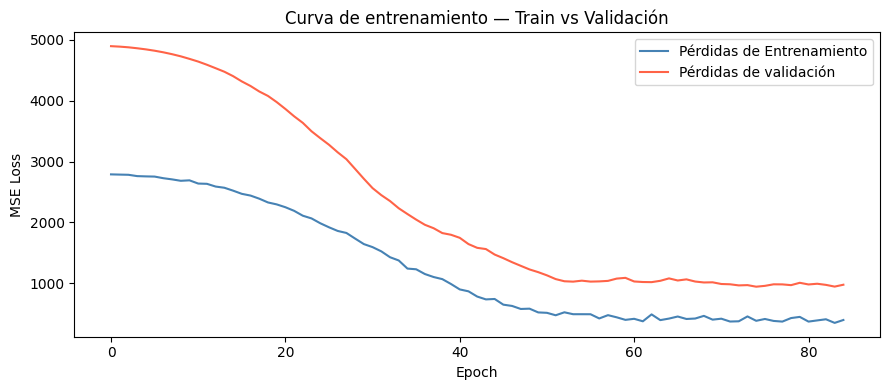

In [92]:
plt.figure(figsize=(9, 4))
plt.plot(train_losses, label='Pérdidas de Entrenamiento', color='steelblue')
plt.plot(val_losses,   label='Pérdidas de validación',   color='tomato')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Curva de entrenamiento — Train vs Validación')
plt.legend()
plt.tight_layout()
plt.savefig('outputs/training_curves.png', dpi=150, bbox_inches='tight')
plt.show()

Podemos notar que ambas curvas llegan a su plateau alrededor de la epoca 50 que es cuando se estabilizan y dejan de presentar una caída tan abrupta a diferencia de  las primeras epocas.

## 8. Evaluación en conjunto de Test

In [93]:
model.eval()
y_pred_list = []
y_true_list = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        pred = model(X_batch)
        y_pred_list.extend(pred.numpy())
        y_true_list.extend(y_batch.numpy())

y_pred = np.array(y_pred_list)
y_true = np.array(y_true_list)

mae  = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2   = r2_score(y_true, y_pred)

print(f"MAE  : {mae:.4f}")
print(f"RMSE : {rmse:.4f}")
print(f"R²   : {r2:.4f}")


MAE  : 21.6990
RMSE : 27.4245
R²   : 0.1209


## 9. Análisis de residuos

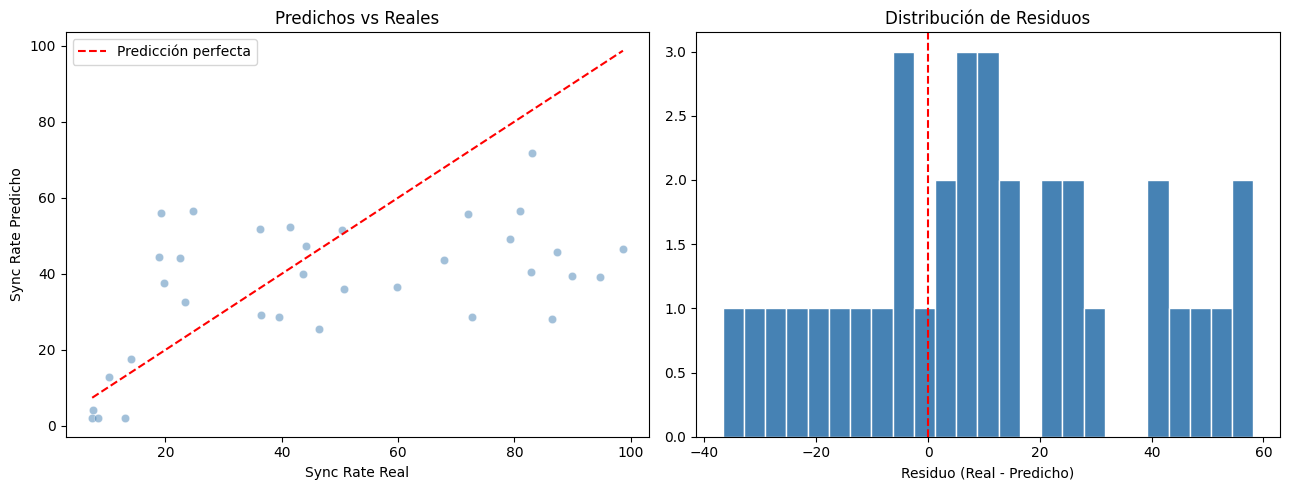

In [94]:
residuos = y_true - y_pred

fig, axes = plt.subplots(1, 2, figsize=(13, 5))

axes[0].scatter(y_true, y_pred, alpha=0.5, color='steelblue', edgecolors='white', linewidth=0.5)
axes[0].plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', linewidth=1.5, label='Predicción perfecta')
axes[0].set_xlabel('Sync Rate Real')
axes[0].set_ylabel('Sync Rate Predicho')
axes[0].set_title('Predichos vs Reales')
axes[0].legend()

axes[1].hist(residuos, bins=25, color='steelblue', edgecolor='white')
axes[1].axvline(0, color='red', linestyle='--', linewidth=1.5)
axes[1].set_xlabel('Residuo (Real - Predicho)')
axes[1].set_title('Distribución de Residuos')

plt.tight_layout()
plt.savefig('outputs/residuals.png', dpi=150, bbox_inches='tight')
plt.show()


## 10. Importancia de features (Permutación)

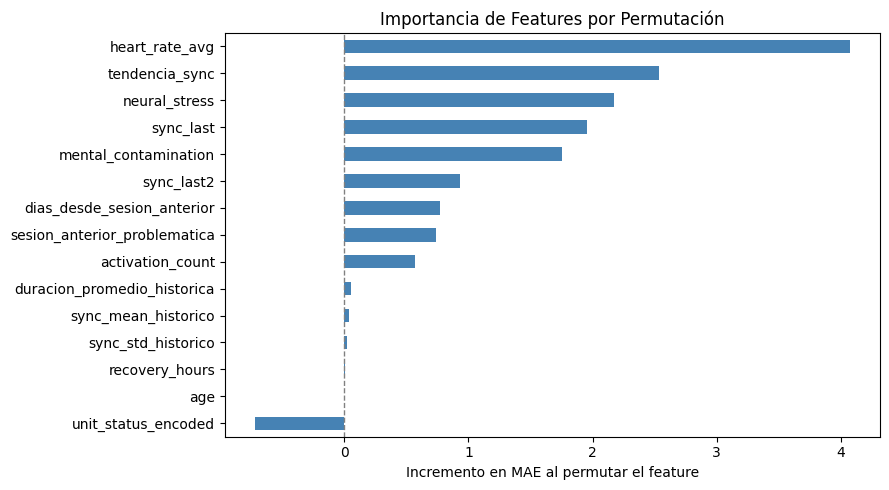

In [95]:
# Para cada feature, lo mezclamos aleatoriamente y medimos cuánto sube el MAE.
# Si al mezclar un feature el error sube mucho, ese feature es importante.
base_mae    = mean_absolute_error(y_true, y_pred)
importancias = []

for i, feature_name in enumerate(features):
    X_permutado = X_test.copy()
    np.random.shuffle(X_permutado[:, i])

    with torch.no_grad():
        pred_perm = model(torch.tensor(X_permutado, dtype=torch.float32)).numpy()

    mae_perm = mean_absolute_error(y_true, pred_perm)
    importancias.append(mae_perm - base_mae)

importancia_df = pd.Series(importancias, index=features).sort_values(ascending=True)

plt.figure(figsize=(9, 5))
importancia_df.plot(kind='barh', color='steelblue')
plt.axvline(0, color='gray', linestyle='--', linewidth=1)
plt.xlabel('Incremento en MAE al permutar el feature')
plt.title('Importancia de Features por Permutación')
plt.tight_layout()
plt.savefig('outputs/feature_importance.png', dpi=150, bbox_inches='tight')
plt.show()


## 11. Guardar modelo entrenado

In [96]:
torch.save(model.state_dict(), 'outputs/model_checkpoint.pt')
print("Modelo guardado en outputs/model_checkpoint.pt")


Modelo guardado en outputs/model_checkpoint.pt


## 12. Conclusiones
A priori, se puede mejorar el modelo planteado optimizando la cantidad de neuronas que posee dentro de su estructura. Además, se puede investigar que otros tipos de features se pueden realizar a partir de los datos generados sinteticamente, además, de excluir aquellos que no aportan al modelo y de ahi realizar iteraciones para obtener mejores modelos. Por ejemplo, del grafico anterior se puede notar que recovery_hours y age no influyen en el incremento del MAE por lo que la informacion de la edad del piloto no es relavante dentro de la calculacion de su sync_rate.
